# Analysis on Drop Validation results
## Drop-trained model (v0)

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import os


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


t5_model = 't5-small'

In [2]:
#choose a version
local_versions = glob.glob('./data/*',recursive=True)
local_versions  = [x for x in local_versions if 'experiments' not in x]
print('versions available locally:')
for x in range(len(local_versions)):
    print(f'{x+1}. {local_versions[x]}')
selection = -1    
while(selection not in range(len(local_versions)+1)):
    selection = input('Enter number: ')
    try:
        selection = int(selection)
    except:
        print('please enter a number')

selection -= 1
version_dir = local_versions[selection]
    
data_dir = f"{version_dir}/{t5_model}"
results_dir = f"{data_dir}/results/"
assert os.path.exists(results_dir), 'error, no results found in folder {}'.format(results_dir)

#choose a results file
files = glob.glob(results_dir+'*.pkl',recursive=True)
for i in range(len(files)):
    print(f'{i+1}. {files[i].rsplit("/",1)[1]}')
selection = -1    
while(selection not in range(len(files)+1)):
    selection = input('Enter number: ')
    try:
        selection = int(selection)
    except:
        print('please enter a number')    
selection -= 1        

print('Importing dataframe of results...')
df = pd.read_pickle(files[selection])
print(f'F1 score: {df.F1.mean():0.5f}')
print(f'EM score: {df.EM.mean():0.5f}')
df.head()

versions available locally:
1. ./data/drop_only-v0
2. ./data/squad-trained-v0
3. ./data/drop_only-v1
4. ./data/processed-data
5. ./data/zeroshot-v0
6. ./data/squad-drop-v0


Enter number:  6


1. drop_validation1109-Jul17.pkl


Enter number:  1


Importing dataframe of results...
F1 score: 0.35607
EM score: 0.31526


,section_id,query_id,passage,question,answers_spans,predicted,EM,F1
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",2,1.0,1.0
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Houston,0.0,0.0
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",10,0.0,0.0


In [100]:
def tag_questions(df):

    df.reset_index(drop=True, inplace = True) #clean up - adding indicies
    
    df['answer_type'] = df.answers_spans.apply(lambda d: d['types'][0])
#     print('answer type value counts: \n',df.answer_type.value_counts())

    df['answers_list'] = df.answers_spans.apply(lambda z: z['spans'])


    df['EasyQ'] = df.apply(lambda z: 1 if len(set(z['passage'].split()).intersection(set(z.answers_list))) > 0 else 0,axis=1)
    df['MathEasyQ'] = np.where((df.EasyQ == 1) &(df.answer_type == 'number'),1,0)
    df['MathHardQ'] = np.where((df.answer_type == 'number')&(df.MathEasyQ == 0),1,0)

    
#     #tag columns
#     question_labels = ['Or','Sort','Who','What','When','Where','How','Which','Boolean']
#     for label in question_labels:
#         df[label] = 0

    df['Or'] = np.where(df.question.str.contains(" or ", flags=re.IGNORECASE), 1, df.Or)
    
    sort_keywords = ["est ","first","last","more","less","better","worse","larger","smaller"]
    
    sort_pat = '|'.join(sort_keywords)
    df['Sort'] = np.where(df.question.str.contains(sort_pat,flags=re.IGNORECASE), 1, df.Sort)

    for q in ['Who','What','When','Where','Why','How','Which']:
        df[q] = np.where(df.question.str.lower().str.contains(q.lower()),1,0)
    
    df['Boolean'] = np.where(df.question.str.startswith('Is'),1,0)
    df['Boolean'] = np.where(df.question.str.startswith('Was'),1,df.Boolean)
    df['Boolean'] = np.where(df.question.str.startswith('Did'),1,df.Boolean)
    df['Boolean'] = np.where(df.question.str.startswith('Were'),1,df.Boolean)
    
    q_list = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean','MathEasyQ','MathHardQ']
    for q in q_list:
        print('question type: {}\n  * count: {:,}\n  * avg F1: {:0.5f}\n  * avg EM: {:0.5f}\n'.format(q,sum(df[q] == 1),df[df[q]==1].F1.mean(),df[df[q]==1].EM.mean()))
        
    df['check_tot'] = df[['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean']].sum(axis=1)
    
    return df

df = tag_questions(df)

question type: Or
  * count: 1,805
  * avg F1: 0.56068
  * avg EM: 0.50139

question type: Sort
  * count: 3,971
  * avg F1: 0.38881
  * avg EM: 0.34550

question type: Who
  * count: 683
  * avg F1: 0.51335
  * avg EM: 0.46413

question type: What
  * count: 596
  * avg F1: 0.43171
  * avg EM: 0.27517

question type: When
  * count: 108
  * avg F1: 0.11204
  * avg EM: 0.08333

question type: Where
  * count: 87
  * avg F1: 0.43885
  * avg EM: 0.36782

question type: Why
  * count: 8
  * avg F1: 0.27375
  * avg EM: 0.12500

question type: How
  * count: 5,955
  * avg F1: 0.27410
  * avg EM: 0.27120

question type: Which
  * count: 1,989
  * avg F1: 0.50888
  * avg EM: 0.39769

question type: Boolean
  * count: 228
  * avg F1: 0.40333
  * avg EM: 0.33772

question type: MathEasyQ
  * count: 361
  * avg F1: 0.32554
  * avg EM: 0.31025

question type: MathHardQ
  * count: 5,528
  * avg F1: 0.27097
  * avg EM: 0.26881



In [3]:
def print_example(query_id,df):
    print('question: ',df.loc[df.query_id == query_id,'question'].iloc[0])
    print('passage: ',df.loc[df.query_id == query_id,'passage'].iloc[0])
    print('\npredicted answer: ',df.loc[df.query_id == query_id,'predicted'].iloc[0])
    print('True answers: ',df.loc[df.query_id == query_id,'answers_spans'].iloc[0])
    print('F1 score: ',df.loc[df.query_id == query_id,'F1'].iloc[0])
    print('EM score: ',df.loc[df.query_id == query_id,'EM'].iloc[0])
    
    
query_id = '0686d1f9-4a8e-4031-b665-49d425afb777'
print_example(query_id,df)

question:  What kind of people were on the ships that arrived at St. Croix in August?
passage:  Danish officials appealed for help to French colonists at Martinique, located 324 miles away. Two French ships arrived from there to St. John on April 23, 1734, carrying several hundred French and Swiss troops to try to take control from the rebels. With their firepower and troops, by mid-May they had restored planters' rule of the island. The French ships returned to Martinique on June 1, leaving the local militia to track down the remaining rebels, which they did over the next three months. The slave insurrection was considered ended on August 25, 1734 when Sergeant Øttingen captured the remaining maroon rebels. The loss of life and property from the insurrection caused many St. John landowners to move to St. Croix, a nearby island bought by the Danish from the French in 1733. Four ships carried planters and their families from Charlotte Amalie in August. While they found St. Croix to be a

In [5]:
query_id = '86dd1721-6bf4-45fa-b01e-de47e4f7301d'
print_example(query_id,df)

question:  How many percent are not Marriage couples living together?
passage:  There were 664,594 households out of which 24.35% had children under the age of 18 living with them, 46.28% were Marriage living together, 11.68% had a female householder with no husband present, and 37.40% were non-families. 30.11% of all households were made up of individuals and 14.70% (4.02% male and 10.68% female) had someone living alone who was 65 years of age or older. The average household size was 2.39 and the average family size was 2.97.

predicted answer:  63.72
True answers:  {'spans': array(['53.72', '46.28', '53.72', '37.4'], dtype=object), 'types': array(['number', 'number', 'number', 'number'], dtype=object)}
F1 score:  0.0
EM score:  0.0


In [6]:
query_id = 'ad19857f-cd76-4d01-ba29-1a589cfee053'
print_example(query_id,df)

question:  How many rushing touchdowns occurred in the game?
passage:   The Eagles faced off with the Baltimore Ravens in an interconference matchup.  Both defenses dominated the first quarter, and in the second quarter, Baltimore forced three turnovers (two interceptions and a fumble) from Donovan McNabb.  Ravens kicker Matt Stover booted a 44-yard field goal, while quarterback Joe Flacco completed a 1-yard touchdown pass to tight end Daniel Wilcox.  However, rookie  Quintin Demps returned the following kickoff 100 yards for a Philadelphia touchdown to make it 10-7 Ravens at halftime.  Andy Reid decided to bench McNabb (who was 8-for-18 for 59 yards and two interceptions) and put backup quarterback Kevin Kolb into the game.  Kolb also struggled with the Baltimore defense, and the Eagles fell behind 12-7 when linebacker Jameel McClain blocked Sav Rocca's punt into the back of the endzone for a safety. In the fourth, the Ravens kicked another field goal after a Kolb interception, then M

In [7]:
df.head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",2,1.0,1.0
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Houston,0.0,0.0
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",10,0.0,0.0


In [24]:
print_example('c78fec38-c81b-4775-a760-ad9cb32f4817',df)

question:  How long did the Sack of Brescia last?
passage:  The Sack of Brescia took place on February 18, 1512 during the War of the League of Cambrai. The city of Brescia had revolted against French control, garrisoning itself with Venetian troops. Gaston de Foix, recently arrived to command the French armies in Italy, ordered the city to surrender; when it refused, he attacked it with around 12,000 men. The French attack took place in a pouring rain, through a field of mud; Foix ordered his men to remove their shoes for better traction. The defenders inflicted heavy casualties on the French, but were eventually overrun, suffering 8,000 - 15,000 casualties. The Gascon infantry and landsknechts then proceeded to thoroughly sack the city, massacring thousands of civilians over the next five days. Following this, the city of Bergamo paid some 60,000 ducats to the French to avoid a similar fate.

predicted answer:  5 days
True answers:  {'spans': array(['5', 'five days', 'five days'], dt

In [21]:
print_example('1f6b2aa8-fd2b-4de2-99ad-6c5fdc4cd267',df)

question:  How many hours was Fox Sports 1 down this year compared to last year?
passage:  The 2018 edition of the U.S. Open featured a total of 37 hours of coverage in the United States, with 19.5 hours being on Thursday and Friday, and 17.5 hours being on Saturday and Sunday; the Fox Sports 1 cable network carried a total of 13.5 hours of coverage on Thursday and Friday. The Fox broadcast network had a total of 23.5 hours of coverage Thursday through Sunday, with 6 hours Thursday and Friday, and 17.5 hours Saturday and Sunday. The overall 37-hour total was down 1.5 hours from last years total of 38.5 hours, due to the Fox broadcast networks coverage having 23.5 hours this year, compared to the 24.5 hours it had last year, and the Fox Sports 1 cable networks 13.5 hours this year, compared to the 14 hours it had last year.

predicted answer:  14
True answers:  {'spans': array(['1.5', '.5'], dtype=object), 'types': array(['number', 'number'], dtype=object)}
F1 score:  0.0
EM score:  0.0

In [16]:
print_example('29648c25-d6fb-4ab3-a8ed-c38e3e493968',df)

question:  How many fewer Soviet prisoners of war were in the official totals than in the Finish estmates?
passage:  According to Finnish historians, the casualties of the Finnish Defence Forces amounted to 63,204 dead or missing and around 158,000 wounded. Officially, the Soviets captured 2,377 Finnish prisoners of war in the Soviet Union, although Finnish researchers estimated the number to be around 3,500 prisoners. 939 Finnish civilians died in air raids and 190 civilians were killed by Soviet partisans. Germany suffered approximately 84,000 casualties in the Finnish front, 16,400 killed, 60,400 wounded and 6,800 missing. In addition to the original peace terms of restoring the 1940 border, Finland was required to Finnish war reparations to the Soviet Union, conduct War-responsibility trials in Finland, lease Porkkalanniemi to the Soviets as well as ban fascist elements and allow left-wing groups, such as the Communist Party of Finland. A Soviet-led Allied Control Commission was in

In [15]:
print_example('dc25acdd-3478-445f-becd-ce26caaca231',df)

question:  How many people in total would occupy 6 square miles of this county based on the population density in the census of 2000?
passage:  As of the census of 2000, there were 445,342 people, 169,162 households, and 114,015 families residing in the county.  The population density was 615 people per square mile (238/km²).  There were 178,913 housing units at an average density of 247 per square mile (95/km²).  The racial makeup of the county was 82.19% Race (United States Census), 1.15% Race (United States Census) or Race (United States Census), 0.65% Race (United States Census), 6.68% Race (United States Census), 0.30% Race (United States Census), 5.86% from Race (United States Census), and 3.17% from two or more races.  11.17% of the population were Race (United States Census) or Race (United States Census) of any race. 17.2% were of German American, 9.9% English American, 8.2% Irish American, and 6.7% Americans ancestry. 81.7% spoke only English at home, while 9.6% spoke Spanish

In [20]:
df[df.MathHardQ == 1].head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",2,1.0,1.0,number,"[2, 3, 3, 3, 3]",0,0,1
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0,number,"[2, 2, 2, 2, 2]",0,0,1
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",10,0.0,0.0,number,"[29, 20, 29, 29, 29]",0,0,1
7,nfl_1184,03fdc8a0-d62b-49a0-8087-af92e6659650,Hoping to rebound from their loss to the Patr...,How many field goals did Sebastian Janikowski ...,"{'spans': ['2', '5'], 'types': ['number', 'num...",2,1.0,1.0,number,"[2, 5]",0,0,1
8,nfl_1184,17bdcfb1-8ad9-46b5-8a3b-1f9769dfd60a,Hoping to rebound from their loss to the Patr...,How many yards difference is there between Seb...,"{'spans': ['3', '3', '3', '3'], 'types': ['num...",11,0.0,0.0,number,"[3, 3, 3, 3]",0,0,1


In [19]:
print_example('f37e81fa-ef7b-4583-b671-762fc433faa9',df)

question:  Who scored the first touchdown of the game?
passage:   Hoping to rebound from their loss to the Patriots, the Raiders stayed at home for a Week 16 duel with the Houston Texans.  Oakland would get the early lead in the first quarter as quarterback JaMarcus Russell completed a 20-yard touchdown pass to rookie wide receiver Chaz Schilens.  The Texans would respond with fullback Vonta Leach getting a 1-yard touchdown run, yet the Raiders would answer with kicker Sebastian Janikowski getting a 33-yard and a 30-yard field goal.  Houston would tie the game in the second quarter with kicker Kris Brown getting a 53-yard and a 24-yard field goal. Oakland would take the lead in the third quarter with wide receiver Johnnie Lee Higgins catching a 29-yard touchdown pass from Russell, followed up by an 80-yard punt return for a touchdown.  The Texans tried to rally in the fourth quarter as Brown nailed a 40-yard field goal, yet the Raiders' defense would shut down any possible attempt.

pr

In [14]:
df[['EasyQ','MathEasyQ','MathHardQ']].describe()

,EasyQ,MathEasyQ,MathHardQ
count,9535.0,9535.000000,9535.0
mean,1.0,0.617619,0.0
std,0.0,0.485994,0.0
min,1.0,0.000000,0.0
25%,1.0,0.000000,0.0
50%,1.0,1.000000,0.0
75%,1.0,1.000000,0.0
max,1.0,1.000000,0.0


In [47]:
df.MathEasy.describe()

count    9535.000000
mean        0.617619
std         0.485994
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: MathEasy, dtype: float64

In [36]:
df[df.answers_list.isin(df.question)].head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,Or,...,Who,What,When,Where,Why,How,Which,Boolean,answers_pat,answers_list


In [35]:
df.head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,Or,...,Who,What,When,Where,Why,How,Which,Boolean,answers_pat,answers_list
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0,span,0,...,0,0,0,0,0,0,0,0,"[Chaz Schilens, JaMarcus Russell]","[Chaz Schilens, JaMarcus Russell]"
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",2,1.0,1.0,number,0,...,0,0,0,0,0,0,0,0,"[2, 3, 3, 3, 3]","[2, 3, 3, 3, 3]"
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Houston,0.0,0.0,span,0,...,0,0,0,0,0,0,0,0,"[Raiders, Raiders, Raiders, the Raiders, the R...","[Raiders, Raiders, Raiders, the Raiders, the R..."
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0,number,0,...,0,0,0,0,0,0,0,0,"[2, 2, 2, 2, 2]","[2, 2, 2, 2, 2]"
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",10,0.0,0.0,number,0,...,0,0,0,0,0,0,0,0,"[29, 20, 29, 29, 29]","[29, 20, 29, 29, 29]"


In [106]:
q_list = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean','MathEasyQ','MathHardQ']
all_count = []
all_F1 = []
all_EM = []

for q in q_list:
    count = sum(df[q] == 1)
    F1 = df[df[q]==1].F1.mean()
    EM = df[df[q]==1].EM.mean()
    all_count.append(count)
    all_F1.append(F1)
    all_EM.append(EM)
    


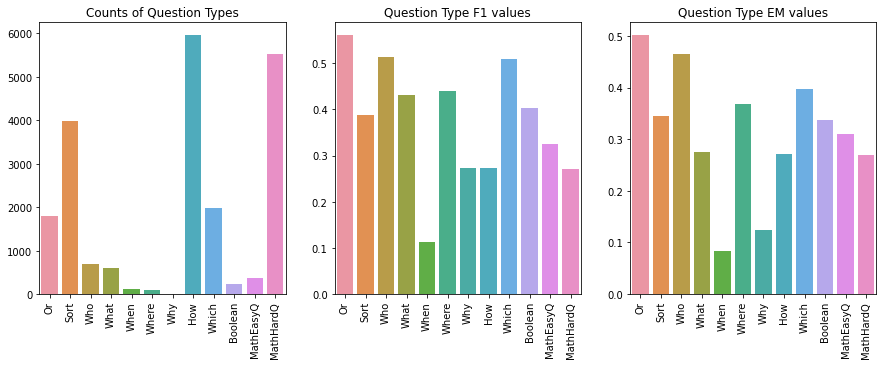

In [116]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))

ax[0] = sns.barplot(x=q_list,y=all_count,ax=ax[0])
_=ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
_=ax[0].set_title('Counts of Question Types')

ax[1] = sns.barplot(x=q_list,y=all_F1,ax=ax[1])
_=ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
_=ax[1].set_title('Question Type F1 values')

ax[2] = sns.barplot(x=q_list,y=all_EM,ax=ax[2])
_=ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=90)
_=ax[2].set_title('Question Type EM values')

In [122]:
df.head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0,span,"[Chaz Schilens, JaMarcus Russell]",0,0,0,0,1,1,0,0,0,0,0,0,0,2
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",2,1.0,1.0,number,"[2, 3, 3, 3, 3]",0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Houston,0.0,0.0,span,"[Raiders, Raiders, Raiders, the Raiders, the R...",1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0,number,"[2, 2, 2, 2, 2]",0,0,1,0,1,0,0,0,0,0,1,0,0,2
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",10,0.0,0.0,number,"[29, 20, 29, 29, 29]",0,0,1,0,1,0,0,0,0,0,1,0,0,2


In [102]:
df.check_tot.value_counts()

1    4995
2    3196
3    1313
4      26
0       5
Name: check_tot, dtype: int64

In [104]:
print_example('95717e8a-3e01-44ac-9ad8-ebdc8746f3c0',df)

question:  THE PROTESTANT CHURCH ADOPTED TWO PRACTICES THAT THE DUTCH REFORMED CHURCH OPPOSES
passage:  The Dutch Reformed Church remained the largest church body in the Netherlands until the middle of the 20th century, when it was overtaken by the Roman Catholic Church. The rapid secularisation of the Netherlands in the 1960s dramatically reduced participation in the mainstream Protestant church. From the '60s onward, a number of attempts were made to effect a reunion with the Reformed Churches in the Netherlands . This led to the two churches uniting with the Evangelical Lutheran Church in the Kingdom of the Netherlands  to establish the Protestant Church in the Netherlands in 2004. The 2004 merger led to a separation in which a number of congregations and members of the Dutch Reformed Church separated to form the Restored Reformed Church . Estimations of their membership vary from 35,000 up to 70,000 in about 120 local congregations served by 88 ministers. The Restored Reformed Chur

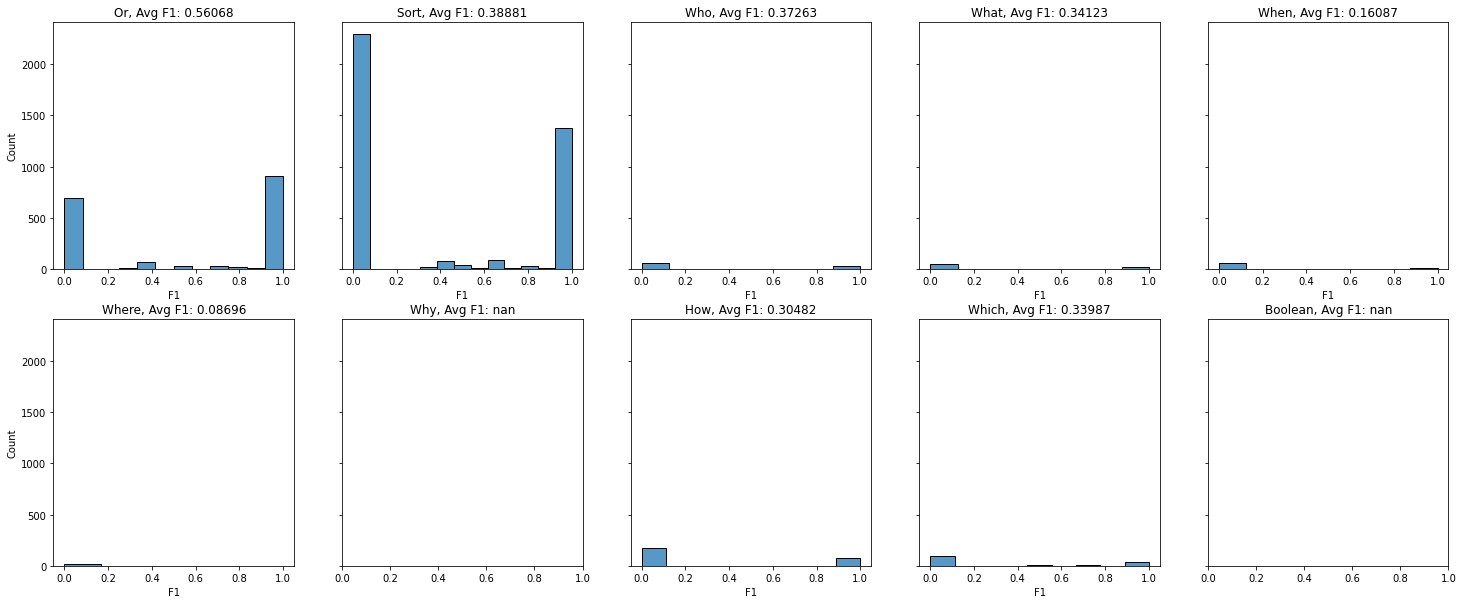

In [72]:
nrows = 2
ncols = 5
counter = 0
qTypes = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean']

fig,ax = plt.subplots(nrows=nrows,ncols=ncols,sharey=True,figsize=(25,10))
for row in range(nrows):
    for col in range(ncols):
        ax[row,col] = sns.histplot(data=df[df[qTypes[counter]]==1],x='F1',label=qTypes[counter],ax=ax[row,col])
        ax[row,col].set_title(f'{qTypes[counter]}, Avg F1: {df[df[qTypes[counter]] == 1].F1.mean():0.5f}')
        counter += 1
    

In [74]:
q_list = ['Or','Who','What','When','Where','How','Which','Boolean','MathEasyQ','MathHardQ']
for q in q_list:
    print('question type: {} + Sort\n  * count: {:,}\n  * avg F1: {:0.5f}\n  * avg EM: {:0.5f}\n'.format(q,sum((df[q] == 1)&(df.Sort == 1)),df[(df[q] == 1)&(df.Sort == 1)].F1.mean(),df[(df[q] == 1)&(df.Sort == 1)].EM.mean()))

question type: Or + Sort
  * count: 1,322
  * avg F1: 0.60442
  * avg EM: 0.53480

question type: Who + Sort
  * count: 29
  * avg F1: 0.16103
  * avg EM: 0.13793

question type: What + Sort
  * count: 12
  * avg F1: 0.48833
  * avg EM: 0.41667

question type: When + Sort
  * count: 21
  * avg F1: 0.25762
  * avg EM: 0.19048

question type: Where + Sort
  * count: 1
  * avg F1: 0.00000
  * avg EM: 0.00000

question type: How + Sort
  * count: 33
  * avg F1: 0.18182
  * avg EM: 0.18182

question type: Which + Sort
  * count: 40
  * avg F1: 0.49750
  * avg EM: 0.45000

question type: Boolean + Sort
  * count: 0
  * avg F1: nan
  * avg EM: nan

question type: MathEasyQ + Sort
  * count: 146
  * avg F1: 0.37678
  * avg EM: 0.36301

question type: MathHardQ + Sort
  * count: 1,796
  * avg F1: 0.19465
  * avg EM: 0.19098



<AxesSubplot:xlabel='F1', ylabel='Count'>

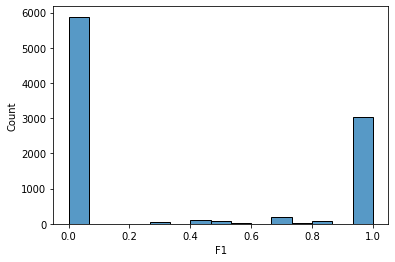

In [70]:
sns.histplot(data=df,x='F1')

In [68]:
df.head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0,span,"[Chaz Schilens, JaMarcus Russell]",0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",2,1.0,1.0,number,"[2, 3, 3, 3, 3]",0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Houston,0.0,0.0,span,"[Raiders, Raiders, Raiders, the Raiders, the R...",1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0,number,"[2, 2, 2, 2, 2]",0,0,1,0,1,0,0,0,0,0,0,0,0,1
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",10,0.0,0.0,number,"[29, 20, 29, 29, 29]",0,0,1,0,1,0,0,0,0,0,0,0,0,1


In [59]:
sum((df.MathHardQ == 1)&(df.Sort == 1))

1796

In [64]:
df[(df.MathHardQ == 1)&(df.Sort == 1)].sample()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
8111,history_2846,bcf578c2-0271-4f54-b980-cb438b34df2d,"As of the census of 2000, there were 14,702 pe...",How many more people are there than housing un...,"{'spans': ['7328', '7328'], 'types': ['number'...",11 33 4,0.0,0.0,number,"[7328, 7328]",0,0,1,0,1,0,0,0,0,0,0,0,0,1


In [65]:

print_example('bcf578c2-0271-4f54-b980-cb438b34df2d',df)

question:  How many more people are there than housing units?
passage:  As of the census of 2000, there were 14,702 people, 5,771 households, and 4,097 families residing in the county.  The population density was 29 people per square mile (11/km²).  There were 7,374 housing units at an average density of 14 per square mile (6/km²).  The racial makeup of the county was 98.02% Race (United States Census), 0.69% Race (United States Census) or Race (United States Census), 0.35% Race (United States Census), 0.11% Race (United States Census), 0.05% Race (United States Census), 0.08% from Race (United States Census), and 0.71% from two or more races.  0.44% of the population were Race (United States Census) or Race (United States Census) of any race.

predicted answer:  11 33 4
True answers:  {'spans': array(['7328', '7328'], dtype=object), 'types': array(['number', 'number'], dtype=object)}
F1 score:  0.0
EM score:  0.0


In [105]:
#really tough MATH & SORT question!!
print_example('c94cef85-f269-43cf-8279-14892239dedf',df)

#another tough MATH SORT
print_example('e2514a1c-07d1-49dc-b987-0dd832b5bd52',df)

question:  How many points did the Ravens score in their two highest scoring games combined?
passage:  Baltimore managed to beat the Jets 10-9 on the 2010 opener, but then lost a poorly-played game against Cincinnati the following week. The Ravens rebounded against the other two division teams, beating Cleveland 24-17 in Week 3 and then Pittsburgh 17-14 in Week 4. The Ravens scored a fine win (31-17) at home against Denver in Week 5. After an overtime loss to New England, they narrowly avoided losing at home to the winless Bills. Next, the Ravens hosted Miami and won 26-10, breaking that teams 4-0 road streak. On Thursday Night, the team headed to Atlanta and lost 26-21 in a game that had some criticizing the officiating. The Ravens finished the season 12-4, second in the division due to a tiebreaker with Pittsburgh, and earning a wild card spot. Baltimore headed to Kansas City and crushed the unprepared Chiefs 30-7, but once again were knocked from the playoffs by Pittsburgh in a hard

In [76]:
df.check_tot.value_counts()

0    4599
1    3471
2    1418
3      47
Name: check_tot, dtype: int64

In [77]:
df[df.check_tot == 0].head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",2,1.0,1.0,number,"[2, 3, 3, 3, 3]",0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Houston,0.0,0.0,span,"[Raiders, Raiders, Raiders, the Raiders, the R...",1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,nfl_1184,03fdc8a0-d62b-49a0-8087-af92e6659650,Hoping to rebound from their loss to the Patr...,How many field goals did Sebastian Janikowski ...,"{'spans': ['2', '5'], 'types': ['number', 'num...",2,1.0,1.0,number,"[2, 5]",0,0,1,0,0,0,0,0,0,0,0,0,0,0
10,nfl_1184,0aa153e9-057a-4347-acb7-8114cb1d68e8,Hoping to rebound from their loss to the Patr...,How many yards longer was the 80-yard punt tha...,"{'spans': ['51', '51', '51', '51'], 'types': [...",10,0.0,0.0,number,"[51, 51, 51, 51]",0,0,1,0,0,0,0,0,0,0,0,0,0,0
11,nfl_1184,142b8af7-b9b0-446b-9cb6-a6940b80461f,Hoping to rebound from their loss to the Patr...,How many touchdowns were scored in the game?,"{'spans': ['4', '4'], 'types': ['number', 'num...",4,1.0,1.0,number,"[4, 4]",0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [78]:
print_example('ac6ba235-3024-4f63-a6ab-730a14def4cb',df)

question:  How many field goals did Kris Brown kick?
passage:   Hoping to rebound from their loss to the Patriots, the Raiders stayed at home for a Week 16 duel with the Houston Texans.  Oakland would get the early lead in the first quarter as quarterback JaMarcus Russell completed a 20-yard touchdown pass to rookie wide receiver Chaz Schilens.  The Texans would respond with fullback Vonta Leach getting a 1-yard touchdown run, yet the Raiders would answer with kicker Sebastian Janikowski getting a 33-yard and a 30-yard field goal.  Houston would tie the game in the second quarter with kicker Kris Brown getting a 53-yard and a 24-yard field goal. Oakland would take the lead in the third quarter with wide receiver Johnnie Lee Higgins catching a 29-yard touchdown pass from Russell, followed up by an 80-yard punt return for a touchdown.  The Texans tried to rally in the fourth quarter as Brown nailed a 40-yard field goal, yet the Raiders' defense would shut down any possible attempt.

pred

In [46]:
df[df.check_tot == 3].head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
92,history_1708,f6fc8e67-5aa2-4a04-b65e-05a154bcc1ae,"In 1905, 1,003 Korean immigrants, which includ...",Were there more men or women and children who ...,"{'spans': ['men', 'men'], 'types': ['span', 's...",men,1.0,1.00,span,"[men, men]",1,0,0,1,1,1,0,0,0,0,0,0,0,3
927,history_124,0afb7ff3-b6f9-4f37-8539-5eaa19a43506,After twelve years of peace following the Indi...,What happened first: Anglo-Powhatan War began ...,"{'spans': ['Anglo-Powhatan War', 'Anglo-Powhat...",Anglo-Powhatan War began,0.0,0.86,span,"[Anglo-Powhatan War, Anglo-Powhatan War]",0,0,0,1,1,0,1,0,0,0,0,0,0,3
930,history_124,b19dc021-b39d-46a2-a7b7-c5dcfd6dfe8a,After twelve years of peace following the Indi...,What happened first: Indian Wars or Anglo-Powh...,"{'spans': ['Indian Wars', 'Indian Wars'], 'typ...",Indian Wars,1.0,1.00,span,"[Indian Wars, Indian Wars]",0,0,0,1,1,0,1,0,0,0,0,0,0,3
1158,history_1227,e08a599f-39cc-4d28-8092-1ccaf367247d,"Franconia is named after the Franks, a Germani...","who become the first Duke of franconia, the Wü...","{'spans': ['Würzburg bishops', 'the Würzburg b...",Würzburg bishops,1.0,1.00,span,"[Würzburg bishops, the Würzburg bishops]",0,0,0,1,1,1,0,0,0,0,0,0,0,3
2245,history_1952,8907fa34-5ac1-425c-9a66-b412387f8ac9,"As of the census of 2000, there were 25,764 pe...","which has more, housing units or households?","{'spans': ['housing units', 'housing units'], ...",housing units,1.0,1.00,span,"[housing units, housing units]",0,0,0,1,1,0,0,0,0,0,0,1,0,3


In [47]:
print_example('f6fc8e67-5aa2-4a04-b65e-05a154bcc1ae',df)

question:  Were there more men or women and children who departed from the port of Chemulpo, Incheon aboard the ship Ilford to Salina Cruz, Oaxaca, Mexico?
passage:  In 1905, 1,003 Korean immigrants, which included 802 men and 231 women and children, departed from the port of Chemulpo, Incheon aboard the ship Ilford to Salina Cruz, Oaxaca, Mexico. The journey took 45 days, after which they took a train to Coatzacoalcos, Veracruz. In the Veracruz port, another boat was taken to the port of Progreso with the final destination being the capital city of Mérida, Yucatan. They arrived in May 1905, with previously signed contracts for four years' work as indentured laborers on the Yucatán henequen haciendas. Many of these Koreans were distributed throughout the Yucatán in 32 henequen haciendas. The town of Motul, Yucatan, located in the heart of the henequen zone, was a destination for many of the Korean immigrants. Subsequently, in 1909, at the end of their contracts, they began a new stage 

In [ ]:
pd.set_options

In [43]:
df.loc[df.query_id == 'e08a599f-39cc-4d28-8092-1ccaf367247d',:]

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
1158,history_1227,e08a599f-39cc-4d28-8092-1ccaf367247d,"Franconia is named after the Franks, a Germani...","who become the first Duke of franconia, the Wü...","{'spans': ['Würzburg bishops', 'the Würzburg b...",Würzburg bishops,1.0,1.0,span,"[Würzburg bishops, the Würzburg bishops]",0,0,0,1,1,1,0,0,0,0,0,0,1,4


In [36]:
q_list = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean']
for q in q_list:
    print('question: ',q,'  count: {}\n'.format(sum(df[q] == 1)))

question:  Or   count: 1805

question:  Sort   count: 3478

question:  Who   count: 95

question:  What   count: 81

question:  When   count: 69

question:  Where   count: 23

question:  Why   count: 0

question:  How   count: 255

question:  Which   count: 149

question:  Boolean   count: 3187



In [37]:
df[df.Sort == 1].sample(4)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,...,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean
1731,nfl_2151,be734e26-8891-402c-bed9-c2a416c190d7,"Coming off a week 2 loss, the Ravens were det...",How many touchdown catches did Smith catch in ...,"{'spans': ['3', '3'], 'types': ['number', 'num...",1,0.0,0.0,number,"[3, 3]",...,0,1,0,0,0,0,0,0,0,0
3014,history_459,6602b9c7-88df-4cf2-9418-a3bf04918777,The Dutch Reformed Church remained the largest...,"Which event happened first, the Roman Catholic...","{'spans': ['overtaken by the Roman Catholic'],...",Dutch Reformed Church separated,0.0,0.0,span,[overtaken by the Roman Catholic],...,1,1,0,0,0,0,0,0,0,0
7321,history_3115,9266969b-b54c-4e62-a06b-578ad620016f,"The census of 2000 showed there were 137,893 p...",How many more people are there than households?,"{'spans': ['79783', '79783'], 'types': ['numbe...",11 11 0,0.0,0.0,number,"[79783, 79783]",...,0,1,0,0,0,0,0,0,0,0
7536,history_2788,e546bbef-51ef-4ea7-8bcb-291513cc5f28,"As of the census of 2000, there were 952 peopl...",How many in percent from the census weren't fr...,"{'spans': ['97.48', '97.48'], 'types': ['numbe...",97.48,1.0,1.0,number,"[97.48, 97.48]",...,1,1,0,0,0,0,0,0,0,0


In [10]:
qTypes = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean'] #,'Math'
df[qTypes].sum()

Or         1805
Sort       3700
Who         587
What        517
When         39
Where        64
Why           8
How        5695
Which      1841
Boolean      50
dtype: int64

In [11]:
for qtype in qTypes:
    print(f'Question type: {qtype}')
    print(f'* Number of questions: {len(df[df[qtype] == 1])}')
    print(f'* Average F1 score: {df[df[qtype] == 1].F1.mean():0.5f}')
    print(f'* Average EM score: {df[df[qtype] == 1].EM.mean():0.5f}\n')

Question type: Or
* Number of questions: 1805
* Average F1 score: 0.56068
* Average EM score: 0.50139

Question type: Sort
* Number of questions: 3700
* Average F1 score: 0.35602
* Average EM score: 0.31324

Question type: Who
* Number of questions: 587
* Average F1 score: 0.53871
* Average EM score: 0.48552

Question type: What
* Number of questions: 517
* Average F1 score: 0.45168
* Average EM score: 0.28627

Question type: When
* Number of questions: 39
* Average F1 score: 0.02564
* Average EM score: 0.02564

Question type: Where
* Number of questions: 64
* Average F1 score: 0.56531
* Average EM score: 0.46875

Question type: Why
* Number of questions: 8
* Average F1 score: 0.27375
* Average EM score: 0.12500

Question type: How
* Number of questions: 5695
* Average F1 score: 0.27268
* Average EM score: 0.26989

Question type: Which
* Number of questions: 1841
* Average F1 score: 0.52282
* Average EM score: 0.40956

Question type: Boolean
* Number of questions: 50
* Average F1 score

In [12]:
df[df.How == 1].sample(5)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,Or,Sort,Math,Who,What,When,Where,Why,How,Which,Boolean
6601,history_1408,af691816-ba56-457b-9650-e3383b4e044a,From 1623 to 1624 the Dutch had been at war ov...,How many more men were there at Fort Zeelandia...,"{'spans': ['1300', '1300', '1300', '1300', '13...",10 00,0.0,0.0,number,0,1,0,0,0,0,0,0,1,0,0
6271,history_115,517c809e-a82c-44de-8c23-e1e12060a673,Air temperature is stable over the year at 26 ...,How many percentage points differentiate the s...,"{'spans': ['1.5'], 'types': ['number']}",1.5,1.0,1.0,number,0,1,0,0,0,0,0,0,1,0,0
1062,history_1959,b14cda6c-bbfd-46bf-b028-a20328652aca,The 2010 United States Census reported that La...,How many percent of people were not white?,"{'spans': ['26.8', '26.8'], 'types': ['number'...",36.8,0.0,0.0,number,0,0,0,0,0,0,0,0,1,0,0
178,nfl_2931,57cb332f-5bd6-44bd-bd47-66e9de573939,"This game involved a scary moment, after Seat...",How many touchdowns did the Cowboys score?,"{'spans': ['0', '0'], 'types': ['number', 'num...",1,0.0,0.0,number,0,0,0,0,0,0,0,0,1,0,0
4049,history_986,fb839fe2-8d33-4691-a0bc-c7e0d61efeab,"At Pagan, the new king Kyawswa controlled just...",How many former Pagan commanders of nearby Myi...,"{'spans': ['3', '3', '3'], 'types': ['number',...",3,1.0,1.0,number,0,0,0,0,0,0,0,0,1,0,0


In [17]:
df[df.How == 1].sample(5)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,Or,Sort,Math,Who,What,When,Where,Why,How,Which,Boolean
822,history_2088,6cdc3853-99f0-40cb-b903-dce675ea30e9,"Skopje, as the Republic of Macedonia as a whol...",How many in percent from the census in Skopje ...,"{'spans': ['33.25', '169198'], 'types': ['numb...",63.35,0.0,0.0,number,0,0,0,0,0,0,0,0,1,0,0
7372,nfl_1361,959c0f71-abe9-47f1-bc8f-2ec87c7d788a,Hoping to rebound from their loss to the Tita...,How many more total field goal yards did Rian ...,"{'spans': ['2', '47'], 'types': ['number', 'nu...",11,0.0,0.0,number,0,1,0,0,0,0,0,0,1,0,0
3322,nfl_624,0baf1424-bf0e-48a3-b3f6-2379bc278674,Coming off their impressive home win over the...,How many yards longer was Sage Rosenfels' touc...,"{'spans': ['4', '4'], 'types': ['number', 'num...",1,0.0,0.0,number,0,0,0,0,0,0,0,0,1,0,0
6913,history_1308,f36bae23-6b4b-46de-bc9a-7fcc233905da,Russia admitted that three of its Su-25 strike...,"How many tanks, armoured and non-armoured lose...","{'spans': ['55', '55'], 'types': ['number', 'n...",3,0.0,0.0,number,0,1,0,0,0,0,0,0,1,0,0
7652,nfl_1240,e3e09455-d467-42b0-8f0d-2a0ad733d145,Coming off their divisional home win over the...,How many yards did Tony Romo throw for on touc...,"{'spans': ['86', '86'], 'types': ['number', 'n...",10,0.0,0.0,number,0,0,0,0,0,0,0,0,1,0,0


In [18]:
print_example('29b34c2b-89ad-4697-bdfc-5cee4e64830e',df)

question:  How many US$ was the difference between the highest GDP and the lowest?
passage:  Since the 1980s, the economy has slowly become less centralized; the annual rate of GDP growth of the Federal District from 2003 to 2004 was the smallest of all federal entities at 0.2%, with drastic drops in the agriculture and industrial sectors. Nonetheless, it still accounts for 21.8% of the nations GDP. The states with the highest GDP growth rates are Quintana Roo (9.0%), Baja California (8.9%), and San Luis Potosí (8.2%). In 2000, the federal entities with the highest GDP per capita in Mexico were the Federal District (US $26,320), Campeche (US $18,900) and Nuevo León (US $30,250); the states with the lowest GDP per capita were Chiapas (US $3,302), Oaxaca (US $4,100) and Guerrero (US $6,800).

predicted answer:  10 00 0
True answers:  {'spans': array(['26948', '19520'], dtype=object), 'types': array(['number', 'number'], dtype=object)}
F1 score:  0.0
EM score:  0.0


In [19]:
print_example('f01bc2c5-d683-44cb-988d-b6aed9bdb049',df)

question:  How many percent do not have children under the age of 18 living with them?
passage:  There were 88,296 households out of which 29.5% had children under the age of 18 living with them, 53.3% were Marriage living together, 9.1% had a female householder with no husband present, and 33.4% were non-families. 26.1% of all households were made up of individuals, 31.5% of households had individuals under 18 years, and 9.5% had someone living alone who was 65 years of age or older.  The average household size was 2.44 and the average family size was 2.96.

predicted answer:  70.5
True answers:  {'spans': array(['68.5', '70.5'], dtype=object), 'types': array(['number', 'number'], dtype=object)}
F1 score:  1.0
EM score:  1.0


In [20]:
print_example('bb96ca91-0c34-420d-85d3-ef723e8b8853',df)

question:  How many points were scored in total in the 1st half?
passage:   After a tough loss at home, the Bengals would remain at home for a game against the Bears.  In the first quarter, the Bears took an early lead when Jordan Howard ran for a 21-yard touchdown (with a failed PAT) to make it 6-0.  The Bengals however took the lead later on in the quarter when Andy Dalton found Brandon LaFell on a 14-yard pass to make it 7-6.  The Bears retook the lead in the second quarter when Mike Nugent kicked 2 field goals:  From 34 and 27 yards out to make it 9-7 and then 12-7 at halftime.  The Bears then shut out the Bengals the entire second half while they score themselves:  In the third quarter Mitchell Trubisky ran for a 4-yard touchdown to make it 19-7 for the only score of the third quarter.  In the fourth quarter, they wrapped up the scoring when Trubisky found Adam Shaheen on a 1-yard pass to make it 26-7.  Howard then ran for an 8-yard touchdown to make the final score 33-7. With the

In [ ]:
df[df.When == 1].head()

In [ ]:
df.loc[69,'predicted']

In [ ]:
df.loc[69,'answers_spans']

In [ ]:
df.loc[69,'passage']

In [ ]:
df.loc[69,'question']

In [ ]:
nrows = 2
ncols = 5
counter = 0
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(25,10))
for row in range(nrows):
    for col in range(ncols):
        ax[row,col] = sns.histplot(data=df[df[qTypes[counter]]==1],x='F1',label=qTypes[counter],ax=ax[row,col])
        ax[row,col].set_title(f'{qTypes[counter]}, Avg F1: {df[df[qTypes[counter]] == 1].F1.mean():0.5f}')
        counter += 1
    